# Part-04A: Deep NLP Text Preparation [ `PyTorch Version` ] 

# Crash Course: Moving from TensorFlow-Keras to PyTorch-Keras

## Introduction

Switching from TensorFlow with Keras to PyTorch can seem daunting, but with a structured approach, it becomes a smooth transition. This guide will help you get started with PyTorch and familiarize you with its equivalents to TensorFlow-Keras functionalities.

### Installing PyTorch and Keras

You've already installed PyTorch using Conda. Now, let's install the necessary libraries if you haven't done so yet:

```bash
conda install pytorch::pytorch torchvision torchaudio -c pytorch
pip install keras
```

## Key Differences Between TensorFlow-Keras and PyTorch-Keras

### 1. **Model Building**

In TensorFlow-Keras, you define a model using the `Sequential` API or the `Functional` API. In PyTorch, models are defined as classes inheriting from `torch.nn.Module`.

#### TensorFlow-Keras Example

```python
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define a simple model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
```

#### PyTorch-Keras Example

```python
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleModel()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

### 2. **Data Loading**

TensorFlow-Keras provides `tf.data.Dataset` for data loading, whereas PyTorch uses `torch.utils.data.DataLoader`.

#### TensorFlow-Keras Example

```python
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)
```

#### PyTorch-Keras Example

```python
from torchvision import datasets, transforms

# Transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load training and test data
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
```

### 3. **Training Loop**

TensorFlow-Keras abstracts the training loop with `model.fit()`. In PyTorch, you need to define the training loop manually, which gives more flexibility.

#### TensorFlow-Keras Example

```python
model.fit(train_ds, epochs=5)
```

#### PyTorch-Keras Example

```python
# Training loop
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')
```

### 4. **Evaluation**

Evaluating models is also different in PyTorch since there is no direct `model.evaluate()` equivalent.

#### TensorFlow-Keras Example

```python
model.evaluate(test_ds)
```

#### PyTorch-Keras Example

```python
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients for evaluation
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
```

## Conclusion

Transitioning from TensorFlow-Keras to PyTorch-Keras involves understanding some key differences in model building, data loading, training, and evaluation processes. PyTorch provides more flexibility and control over the entire deep learning workflow, making it a powerful tool for researchers and developers.

By adapting the examples above, you can start building and training your models in PyTorch-Keras. Happy coding!

# Original Notebook

## Introduction

Deep learning models have shown great potential in processing and understanding large volumes of text data. This notebook is dedicated to preparing text data for deep learning models using TensorFlow. We will cover essential steps such as creating train-test-validation splits, using Keras' TextVectorization layer, and building and evaluating various neural network models.

#### Objectives

1. **Prepare Data for Deep Learning**:
   - Load and preprocess the Amazon Product Reviews dataset.
   - Create train-test-validation splits to ensure robust model training and evaluation.

2. **Text Vectorization**:
   - Utilize Keras' TextVectorization layer to convert raw text into sequences of integers.
   - Determine appropriate sequence lengths and batch the data for efficient processing.

3. **Use Pre-trained Word Embeddings**:
   - Load and utilize pre-trained GloVe word embeddings to enrich the text data with semantic information.
   - Perform operations such as similarity checks and word arithmetic to explore the embeddings.

4. **Build and Evaluate Neural Network Models**:
   - Build and compile various neural network architectures, including Simple RNN, LSTM, GRU, and Attention models.
   - Train the models using the prepared data and evaluate their performance using appropriate metrics.

By the end of this notebook, we will have a set of well-prepared text data and trained deep learning models ready for further analysis and deployment. This preparation ensures that our models can effectively process and understand the text data, providing valuable insights and accurate predictions.


In [1]:
# Adding parent directory to python path
import sys, os
sys.path.append( os.path.abspath('../'))

In [2]:
# # %conda install -y apple::tensorflow-deps
# !python3 -m pip install tensorflow-macos
# # !python3 -m pip install tensorflow-metal

In [3]:
# ## Load the autoreload extension
# !pip install -U dojo_ds -q
# import dojo_ds as ds
# # %load_ext autoreload 
# # %autoreload 2

# # import custom_functions_SOLUTION  as fn

## Data

In [4]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [5]:
# !pip install tensorflow-macos"<2.13"
# !pip install tensorflow-metal
# !pip install tf_keras

In [6]:
# conda list tensorflow

In [7]:
import sys, os


# os.environ['TF_USE_LEGACY_KERAS']='1'


import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')
print(f"{tf.__version__=}")

tf.__version__='2.16.2'


In [8]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [9]:
import json, joblib
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS['data']['ml-nlp']

{'train_joblib': 'data/modeling/training-data.joblib',
 'test_joblib': 'data/modeling/testing-data.joblib'}

In [51]:
## Load the autoreload extension
# !pip install -U dojo_ds
import dojo_ds as fn
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_SOLUTION  as fn

## Function Code

In [11]:
# fn.show_code(fn.evaluate.evaluate_classification_network)
# fn.show_code(evpy.evaluate.classification_metrics)
# fn.show_code(fn.evaluate.convert_y_to_sklearn_classes)

## From Train-Test Split for ML to Train-Test-Val Split for ANNs

In [12]:
X_train, y_train = joblib.load(FPATHS['data']['ml-nlp']['train_joblib'])
X_test, y_test = joblib.load(FPATHS['data']['ml-nlp']['test_joblib'])

- Can't use text labels with neural networks.

In [13]:
# Instansiate label encoder
# encoder = joblib.load()...LabelEncoder()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import joblib

In [15]:
'encoder' in str(FPATHS)#['models'][ml]

True

In [16]:
encoder=  joblib.load(FPATHS['metadata']['label_encoder_joblib'])
encoder

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LabelEncoder()

In [17]:
# encoder = joblib.load(FPATHS['models']['ml']['encoder'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.97      0.98      0.98      1376
         Low       0.97      0.96      0.97      1102

    accuracy                           0.97      2478
   macro avg       0.97      0.97      0.97      2478
weighted avg       0.97      0.97      0.97      2478



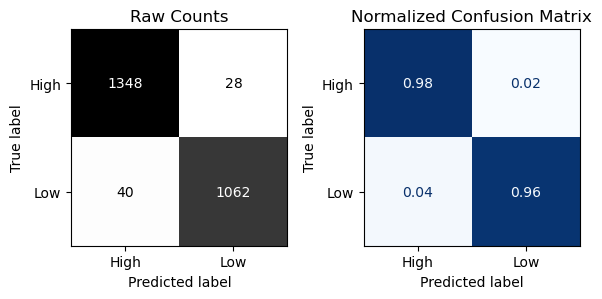


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.93      0.98      0.96       492
         Low       0.96      0.90      0.93       335

    accuracy                           0.95       827
   macro avg       0.95      0.94      0.94       827
weighted avg       0.95      0.95      0.95       827



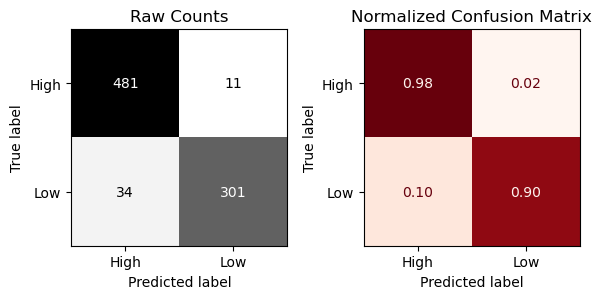

In [18]:
## Create a model pipeline 
count_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
                       ('naivebayes',  MultinomialNB())])

count_pipe.fit(X_train, y_train)
fn.evaluate.evaluate_classification(count_pipe, X_train, y_train, X_test, y_test,target_names=encoder.classes_)

In [19]:
# # Admin: Saving  for Demo functions in part 1
# import joblib
# fpath_joblib = "../Lecture 1 Pt1 - Making a Custom Module/example-clf-model-with-data.joblib"
# save_for_part1= {'model':count_pipe, 'training data': [X_train, y_train],'test data':[X_test, y_test]}
# joblib.dump(save_for_part1, fpath_joblib)

# Preparing For Deep NLP with `PyTorch` (Train-Test-Val Datasets)

In [20]:
# Create the validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(f"{X_train.shape=} {X_test.shape=} {X_val.shape=}")
print(f"{y_train.shape=} {y_test.shape=} {y_val.shape=}")

X_train.shape=(2478,) X_test.shape=(413,) X_val.shape=(414,)
y_train.shape=(2478,) y_test.shape=(413,) y_val.shape=(414,)


In [21]:
BATCH_SIZE = 32

### Prepare the Tokenizer and Dataset 

In [22]:
from collections import Counter
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence

# Function to tokenize and preprocess the text
def preprocess_text(text):
    # Remove punctuation and lowercase the text
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

def get_vocab(X):
    all_words = [word for review in X for word in preprocess_text(review)]
    vocab = Counter(all_words)
    vocab = {word: i+1 for i, (word, _) in enumerate(vocab.items())}  # Start indexing from 1
    return vocab
vocab = get_vocab(X_train)

# # Create a vocabulary from the training data
# all_words = [word for review in X_train for word in preprocess_text(review)]
# vocab = Counter(all_words)
# vocab = {word: i+1 for i, (word, _) in enumerate(vocab.items())}  # Start indexing from 1

# Tokenizer function
def tokenizer(text):
    tokens = preprocess_text(text)
    return torch.tensor([vocab.get(word, 0) for word in tokens], dtype=torch.long)  # 0 for unknown words

# Padding function to make all sequences the same length
def pad_collate_fn(batch):
    (xx, yy) = zip(*batch)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)  # Padding with 0
    yy = torch.tensor(yy, dtype=torch.float32)
    return xx_pad, yy

In [23]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Define a custom Dataset class
class AmazonReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = self.tokenizer(review)
        return tokens, label
    
    def __repr__(self):
        # Display the number of samples
        info = f"AmazonReviewsDataset with {len(self)} samples\n"
        # Display the first few samples
        info += "First few samples:\n"
        for i in range(min(3, len(self))):
            review = self.reviews.iloc[i]
            label = self.labels.iloc[i]
            info += f"{i+1}. Label: {label}; Review: {review}\n"
        return info

# # Define a simple tokenizer (replace with a more sophisticated one as needed)
# tokenizer = lambda x: torch.tensor([ord(c) for c in x], dtype=torch.long)

# Create dataset and dataloader
train_dataset = AmazonReviewsDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_fn)

# Create dataset and dataloader
val_dataset = AmazonReviewsDataset(X_val, y_val, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_fn)

# Create dataset and dataloader
test_dataset = AmazonReviewsDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,collate_fn=pad_collate_fn)

# Print the number of batches
print(f'Train batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Train batches: 78
Validation batches: 13
Test batches: 13


In [24]:
print(train_dataset)

AmazonReviewsDataset with 2478 samples
First few samples:
1. Label: 0; Review: Great!: This stuff is a miracle. Rinse very well for a few minutes, then boil for a couple minutes, then dry fry it in a pan and trim the pasta. I just made chicken pad thai with it. I made my own sauce so the whole meal was low carb. This is becoming a big part of my diet.
2. Label: 1; Review: Not For Me: When you give up on trying  to chew this up, just swallow it whole.one two three four five six seven
3. Label: 1; Review: Texture is chewy and smelled like fish!: Nasty! Texture is chewy and smelled like fish!



### Create the Training Texts Dataset

In [25]:
sequence_lengths = X_train.map(lambda x: len(x.split(" ")))
sequence_lengths.describe()

count    2478.000000
mean       49.979822
std        60.989205
min         2.000000
25%        13.000000
50%        33.000000
75%        63.000000
max       977.000000
Name: review-text-full, dtype: float64

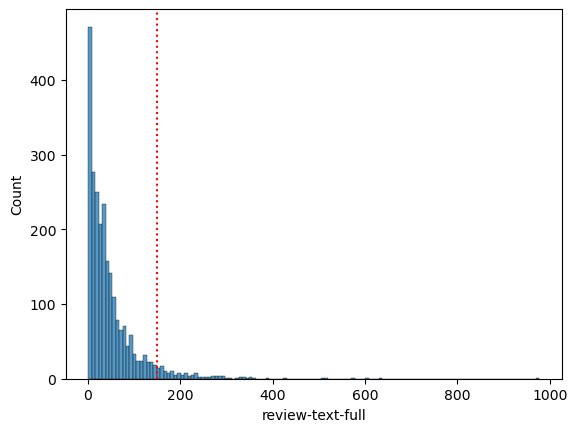

In [26]:
SEQUENCE_LENGTH = 150
ax = sns.histplot(data=sequence_lengths,)# hue='target-rating', x='length (tokens)',kde=True,
                # stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

In [27]:
import torch.nn as nn

# Define embedding parameters
VOCAB_SIZE = 256  # Assuming 256 unique characters for simplicity
EMBED_DIM = 100
SEQUENCE_LENGTH = 50

# Define an embedding layer
embedding_layer = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_DIM)
embedding_layer

Embedding(256, 100)

# Our First Deep Sequence Model

### Simple RNN

In [28]:

# VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
# SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']


# # Define sequential model with pre-trained vectorization layer and *new* embedding layer
# model = Sequential([
#     sequence_vectorizer,
#     layers.Embedding(input_dim=VOCAB_SIZE,
#                               output_dim=EMBED_DIM, 
#                               input_length=SEQUENCE_LENGTH)
#     ])
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size=256, embed_dim=100, hidden_dim=32, output_dim=1):
        super(SimpleRNNModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        # Define the RNN layer
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        # Define the output layer
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        
    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        # Pass the embedded input through the RNN layer
        x, _ = self.rnn(x)
        # Get the last hidden state
        x = self.fc(x[:, -1, :])
        return x


VOCAB_SIZE = 256
EMBED_DIM = 100
HIDDEN_DIM = 32
OUTPUT_DIM = 1

# Instantiate the model
model = SimpleRNNModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
model

SimpleRNNModel(
  (embedding): Embedding(256, 100)
  (rnn): RNN(100, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [29]:
for inputs,labels in train_loader:
    print(inputs.shape)
    # print(model(inputs))

torch.Size([32, 599])
torch.Size([32, 550])
torch.Size([32, 146])
torch.Size([32, 308])
torch.Size([32, 163])
torch.Size([32, 145])
torch.Size([32, 153])
torch.Size([32, 209])
torch.Size([32, 205])
torch.Size([32, 489])
torch.Size([32, 195])
torch.Size([32, 100])
torch.Size([32, 149])
torch.Size([32, 290])
torch.Size([32, 186])
torch.Size([32, 207])
torch.Size([32, 237])
torch.Size([32, 392])
torch.Size([32, 208])
torch.Size([32, 231])
torch.Size([32, 154])
torch.Size([32, 302])
torch.Size([32, 291])
torch.Size([32, 225])
torch.Size([32, 197])
torch.Size([32, 279])
torch.Size([32, 186])
torch.Size([32, 154])
torch.Size([32, 181])
torch.Size([32, 236])
torch.Size([32, 278])
torch.Size([32, 124])
torch.Size([32, 241])
torch.Size([32, 123])
torch.Size([32, 158])
torch.Size([32, 246])
torch.Size([32, 288])
torch.Size([32, 627])
torch.Size([32, 127])
torch.Size([32, 987])
torch.Size([32, 225])
torch.Size([32, 423])
torch.Size([32, 116])
torch.Size([32, 284])
torch.Size([32, 350])
torch.Size

### Training Loop

In [30]:
## Instantiate the model
# Define model parameters
VOCAB_SIZE = len(vocab) + 1  # Add 1 for padding
EMBED_DIM = 100
HIDDEN_DIM = 32
OUTPUT_DIM = 1
# Define number of epocs
EPOCHS = 30

# Instantiate the model
model = SimpleRNNModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)


## Train the model 
# criterion = nn.BCELoss() # Set the loss function
criterion = nn.BCEWithLogitsLoss() # Set the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize the history dictionary
history_dict = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

class History():
    def __init__(self, history_dict=None):
        if history_dict is None:
            history_dict = {
                'loss': [],
                'val_loss': [],
                'accuracy': [],
                'val_accuracy': []
            }
        self.history = history_dict
        n_epochs = len(history_dict['loss'])
        self.epoch = list(range(1, n_epochs+1))
        

# Define the training loop
for epoch in range(EPOCHS):
    model.train() # Set the model to training mode
    
    # initialize the running loss
    running_loss = 0.0
    
    # Set the number of correct predictions and total predictions to 0
    correct_predictions = 0
    total_predictions = 0

    # Loop over the training data
    for inputs,labels in train_loader:

        labels = labels.unsqueeze(1).float()         # Reshape labels for compatibility with BCELoss
        optimizer.zero_grad() # Clear/Zero the parameter gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate the loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize
        running_loss += loss.item()# Update running loss
        
        # Ge predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()    
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
    
    # Calculate the training loss
    train_loss = running_loss / len(train_loader)
    history_dict['loss'].append(train_loss)
    train_accuracy = correct_predictions / total_predictions
    history_dict['accuracy'].append(train_accuracy)
    
    ## Validation Phase
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.unsqueeze(1)  # Reshape labels for compatibility with BCEWithLogitsLoss
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            val_running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct_predictions += (preds == labels).sum().item()
            val_total_predictions += labels.size(0)
    
    # Get the final val loss and accuracy
    val_loss = val_running_loss / len(val_loader)
    history_dict['val_loss'].append(val_loss)

    val_accuracy = val_correct_predictions / val_total_predictions
    history_dict['val_accuracy'].append(val_accuracy)

    msg = f'- Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}; '
    msg += f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}'
    print(f"{msg}")
        
        

- Epoch 1/30: Train Loss: 0.6908, Train Accuracy: 0.5391; Val Loss: 0.6920, Val Accuracy: 0.5580
- Epoch 2/30: Train Loss: 0.6933, Train Accuracy: 0.5270; Val Loss: 0.6874, Val Accuracy: 0.5604
- Epoch 3/30: Train Loss: 0.6873, Train Accuracy: 0.5553; Val Loss: 0.6890, Val Accuracy: 0.5604
- Epoch 4/30: Train Loss: 0.6859, Train Accuracy: 0.5529; Val Loss: 0.6876, Val Accuracy: 0.5628
- Epoch 5/30: Train Loss: 0.6852, Train Accuracy: 0.5553; Val Loss: 0.6900, Val Accuracy: 0.5628
- Epoch 6/30: Train Loss: 0.6846, Train Accuracy: 0.5557; Val Loss: 0.6859, Val Accuracy: 0.5652
- Epoch 7/30: Train Loss: 0.6849, Train Accuracy: 0.5480; Val Loss: 0.6868, Val Accuracy: 0.5652
- Epoch 8/30: Train Loss: 0.6806, Train Accuracy: 0.5504; Val Loss: 0.6860, Val Accuracy: 0.5700
- Epoch 9/30: Train Loss: 0.6818, Train Accuracy: 0.5484; Val Loss: 0.6861, Val Accuracy: 0.5676
- Epoch 10/30: Train Loss: 0.6819, Train Accuracy: 0.5585; Val Loss: 0.6853, Val Accuracy: 0.5676
- Epoch 11/30: Train Loss: 0.

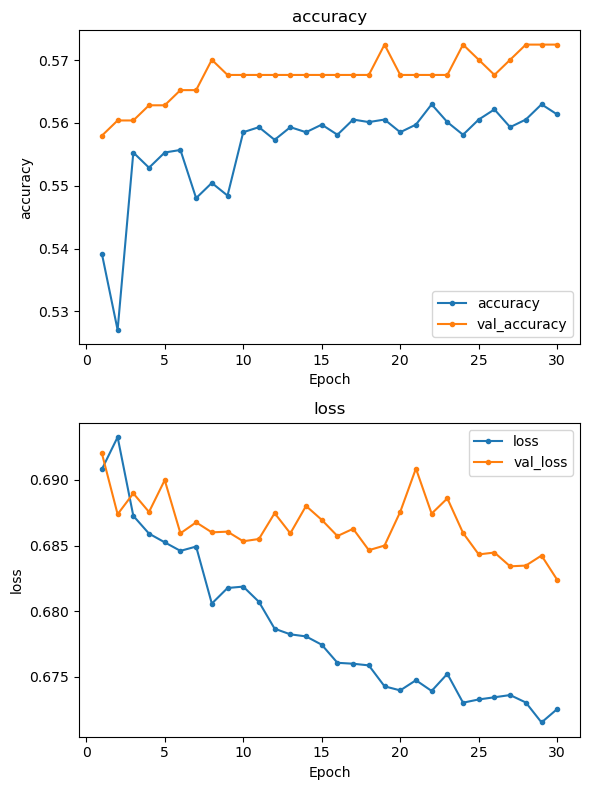

In [31]:
history = History(history_dict)

fn.evaluate.plot_history(history)

In [32]:
fn.show_code(fn.evaluate.plot_history)

```python
def plot_history(history, figsize=(6,8), return_fig=False):
    """Plots the training and validation curves for all metrics in a Tensorflow History object.

    Args:
        history (Tensorflow History): History output from training a neural network.
        figsize (tuple, optional): Total figure size. Defaults to (6,8).
        return_fig (boolean, optional): If true, return figure instead of displaying it with plt.show()

    Returns:
        None or matplotlib.figure.Figure: If return_fig is True, returns the figure object. Otherwise, displays the figure using plt.show().
    """
    import matplotlib.pyplot as plt
    import numpy as np
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
   
    # Adjust subplots and show
    fig.tight_layout()
 
    if return_fig:
        return fig
    else:
        plt.show()

```

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def get_predictions(model, dataloader, convert=True):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in dataloader:
            labels = labels.unsqueeze(1)  # Reshape labels for compatibility with BCELoss
            outputs = model(inputs)  # Forward pass
            preds = (outputs > 0.5).float()  # Convert outputs to binary predictions
            all_labels.extend(labels.numpy())  # Collect true labels
            all_preds.extend(preds.numpy())  # Collect predictions
            
    if convert:
        all_labels = convert_y_to_sklearn_classes(all_labels)
        all_preds = convert_y_to_sklearn_classes(all_preds)
    return all_labels, all_preds


def convert_y_to_sklearn_classes(y, verbose=False):
    """
    Helper function to convert neural network outputs to class labels.

    Args:
        y (array/Series): Predictions to convert to classes.
        verbose (bool, optional): Print which preprocessing approach is used. Defaults to False.

    Returns:
        array: Target as 1D class labels
    """
    import numpy as np
    if isinstance(y,list):
        y = np.array(y)
    # If already one-dimension
    if np.ndim(y) == 1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1] > 1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)
    

In [34]:
# Get training data predictions
train_labels, train_preds = get_predictions(model, train_loader, convert=False)
print(train_labels[:5])
print(train_preds[:5])

# Convert predictions to class labels
train_labels_sklearn = convert_y_to_sklearn_classes(train_labels)
train_preds_sklearn = convert_y_to_sklearn_classes(train_preds)

print(train_labels_sklearn[:5])
print(train_preds_sklearn[:5])


[array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32)]
[array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32)]
[0 1 0 0 0]
[0 0 0 0 0]


In [35]:
# Get training data predictions
train_labels, train_preds = get_predictions(model, train_loader, convert=True)
print(train_labels[:5])
print(train_preds[:5])


[1 1 1 0 0]
[0 0 0 0 0]


In [36]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False, values_format=".2f",
                           target_names = None, return_fig=True):
    """
    Calculate classification metrics from predictions and display Confusion matrix.

    Args:
        y_true (Series/array): True target values.
        y_pred (Series/array): Predicted target values.
        label (str, optional): Label for printed header. Defaults to ''.
        output_dict (bool, optional): Return the results of classification_report as a dict. Defaults to False.
        figsize (tuple, optional): figsize for confusion matrix subplots. Defaults to (8,4).
        normalize (str, optional): Arg for sklearn's ConfusionMatrixDisplay. Defaults to 'true' (conf mat values normalized to true class).
        cmap (str, optional): Colormap for the ConfusionMatrixDisplay. Defaults to 'Blues'.
        colorbar (bool, optional): Arg for ConfusionMatrixDisplay: include colorbar or not. Defaults to False.
        values_format (str, optional): Format values on confusion matrix. Defaults to ".2f".
        target_names (array, optional): Text labels for the integer-encoded target. Passed in numeric order [label for "0", label for "1", etc.].
        return_fig (bool, optional): To get matplotlib figure for confusion matrix, set output_dict to False and set return_fig to True.

    Returns:
        dict: Dictionary from classification_report. Only returned if output_dict=True.
        fig: Matplotlib figure with confusion matrix. Only returned if output_dict=False and return_fig=True.

    Note: 
        This is a modified version of the classification metrics function from Intro to Machine Learning.
        Updates:
          - Reversed raw counts confusion matrix cmap (so darker==more).
          - Added arg for normalized confusion matrix values_format.
    """
    from sklearn.metrics import classification_report, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import numpy as np
    # Get the classification report
    report = classification_report(y_true, y_pred,target_names=target_names)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0], 
                                            display_labels=target_names);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=target_names);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred,target_names=target_names, output_dict=True)
        return report_dict

    elif return_fig == True:
        return fig

In [37]:
# classification_metrics(train_labels_sklearn, train_preds_sklearn, label='Train Set', target_names=['Negative', 'Positive'])

In [38]:
def evaluate_classification_pytorch(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False, target_names=None, 
         return_fig=False):
    
    if (X_train is None) & (X_test is None):
        raise Exception('\nEither X_train & y_train or X_test & y_test must be provided.')
 
    shared_kwargs = dict(output_dict=True, 
                      figsize=figsize,
                      colorbar=colorbar,
                      values_format=values_format, 
                      target_names=target_names,)
    # Plot history, if provided
    # if history is not None:
    #     plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        # Get predictions for training data
        y_train, y_train_pred = get_predictions(model, dataloader=X_train, convert=True)
        
        # Call the helper function to obtain metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, cmap=cmap_train,label='Training Data', **shared_kwargs)
        
        # ## Run model.evaluate         
        # print("\n- Evaluating Training Data:")
        # print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = None
  
  
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        y_test, y_test_pred = get_predictions(model, dataloader=X_test, convert=True)
        
        
        # Call the helper function to obtain metrics for test data
        results_test = classification_metrics(y_test, y_test_pred, cmap=cmap_test,label='Test Data', **shared_kwargs)
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = None
      
    if (output_dict == True) | (return_fig==True):
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                        'test': results_test}
        return results_dict


In [39]:
# fn.show_code(fn.evaluate.evaluate_classification_network)

In [40]:
# fn.show_code(fn.evaluate.classification_metrics)

In [41]:

# # Calculate accuracy
# train_accuracy = accuracy_score(train_labels, train_preds)
# print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# # Classification report
# print("Training Classification Report:")
# print(classification_report(train_labels, train_preds))

# # Confusion matrix
# conf_matrix = confusion_matrix(train_labels, train_preds)
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix")
# plt.show()

## Functionized Training

In [42]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    # Initialize the history dictionary
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }
    
    class History():
        def __init__(self, history_dict=None):
            if history_dict is None:
                history_dict = {
                    'loss': [],
                    'val_loss': [],
                    'accuracy': [],
                    'val_accuracy': []
                }
            self.history = history_dict
            n_epochs = len(history_dict['loss'])
            self.epoch = list(range(1, n_epochs+1))
            
            
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        # Initialize the running loss and correct predictions counters
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Loop over the training data
        for inputs, labels in train_loader:
            labels = labels.unsqueeze(1).float()  # Reshape labels for compatibility with BCEWithLogitsLoss
            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            running_loss += loss.item()  # Update running loss

            # Get predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate the training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                labels = labels.unsqueeze(1)  # Reshape labels for compatibility with BCEWithLogitsLoss
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_running_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct_predictions += (preds == labels).sum().item()
                val_total_predictions += labels.size(0)

        # Calculate the validation loss and accuracy
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        msg = f'- Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}; '
        msg += f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}'
        print(msg)
    
    return History(history)

In [43]:
# Define model parameters
VOCAB_SIZE = len(vocab) + 1  # Add 1 for padding
EMBED_DIM = 100
HIDDEN_DIM = 32
OUTPUT_DIM = 1
EPOCHS = 30

# Instantiate the model
model = SimpleRNNModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

# Set the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model and get the history
history = train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

- Epoch 1/30: Train Loss: 0.6940, Train Accuracy: 0.5323; Val Loss: 0.6845, Val Accuracy: 0.5652
- Epoch 2/30: Train Loss: 0.6889, Train Accuracy: 0.5500; Val Loss: 0.6874, Val Accuracy: 0.5628
- Epoch 3/30: Train Loss: 0.6874, Train Accuracy: 0.5500; Val Loss: 0.6849, Val Accuracy: 0.5604
- Epoch 4/30: Train Loss: 0.6843, Train Accuracy: 0.5565; Val Loss: 0.6851, Val Accuracy: 0.5628
- Epoch 5/30: Train Loss: 0.6829, Train Accuracy: 0.5585; Val Loss: 0.6851, Val Accuracy: 0.5628
- Epoch 6/30: Train Loss: 0.6816, Train Accuracy: 0.5577; Val Loss: 0.6868, Val Accuracy: 0.5628
- Epoch 7/30: Train Loss: 0.6807, Train Accuracy: 0.5581; Val Loss: 0.6851, Val Accuracy: 0.5628
- Epoch 8/30: Train Loss: 0.6800, Train Accuracy: 0.5569; Val Loss: 0.6838, Val Accuracy: 0.5676
- Epoch 9/30: Train Loss: 0.6806, Train Accuracy: 0.5581; Val Loss: 0.6850, Val Accuracy: 0.5628
- Epoch 10/30: Train Loss: 0.6773, Train Accuracy: 0.5569; Val Loss: 0.6839, Val Accuracy: 0.5652
- Epoch 11/30: Train Loss: 0.

## Putting it All Together

In [44]:
# del evpy

In [45]:
%load_ext autoreload
%autoreload 2
from custom_functions import evaluate_pytorch as evpy
# help(evpy)
dir(evpy)

['AmazonReviewsDataset',
 'ConfusionMatrixDisplay',
 'Counter',
 'DataLoader',
 'Dataset',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'classification_metrics',
 'classification_report',
 'convert_y_to_sklearn_classes',
 'evaluate_classification_pytorch',
 'fn',
 'get_predictions',
 'get_vocab',
 'nn',
 'np',
 'pad_collate_fn',
 'pad_sequence',
 'pd',
 'plot_history',
 'plt',
 'preprocess_text',
 're',
 'sns',
 'tokenizer',
 'torch',
 'train_model']

In [46]:
train_data = pd.DataFrame({'review': X_train, 'label': y_train})
test_data = pd.DataFrame({'review': X_test, 'label': y_test})
val_data = pd.DataFrame({'review': X_val, 'label': y_val})

- Epoch 1/30: Train Loss: 0.6995, Train Accuracy: 0.5375; Val Loss: 0.6877, Val Accuracy: 0.5628
- Epoch 2/30: Train Loss: 0.6904, Train Accuracy: 0.5496; Val Loss: 0.6891, Val Accuracy: 0.5604
- Epoch 3/30: Train Loss: 0.6900, Train Accuracy: 0.5464; Val Loss: 0.6882, Val Accuracy: 0.5604
- Epoch 4/30: Train Loss: 0.6867, Train Accuracy: 0.5404; Val Loss: 0.6880, Val Accuracy: 0.5604
- Epoch 5/30: Train Loss: 0.6860, Train Accuracy: 0.5545; Val Loss: 0.6865, Val Accuracy: 0.5652
- Epoch 6/30: Train Loss: 0.6844, Train Accuracy: 0.5545; Val Loss: 0.6862, Val Accuracy: 0.5676
- Epoch 7/30: Train Loss: 0.6823, Train Accuracy: 0.5569; Val Loss: 0.6863, Val Accuracy: 0.5676
- Epoch 8/30: Train Loss: 0.6801, Train Accuracy: 0.5573; Val Loss: 0.6871, Val Accuracy: 0.5676
- Epoch 9/30: Train Loss: 0.6810, Train Accuracy: 0.5573; Val Loss: 0.6868, Val Accuracy: 0.5676
- Epoch 10/30: Train Loss: 0.6789, Train Accuracy: 0.5581; Val Loss: 0.6863, Val Accuracy: 0.5676
- Epoch 11/30: Train Loss: 0.

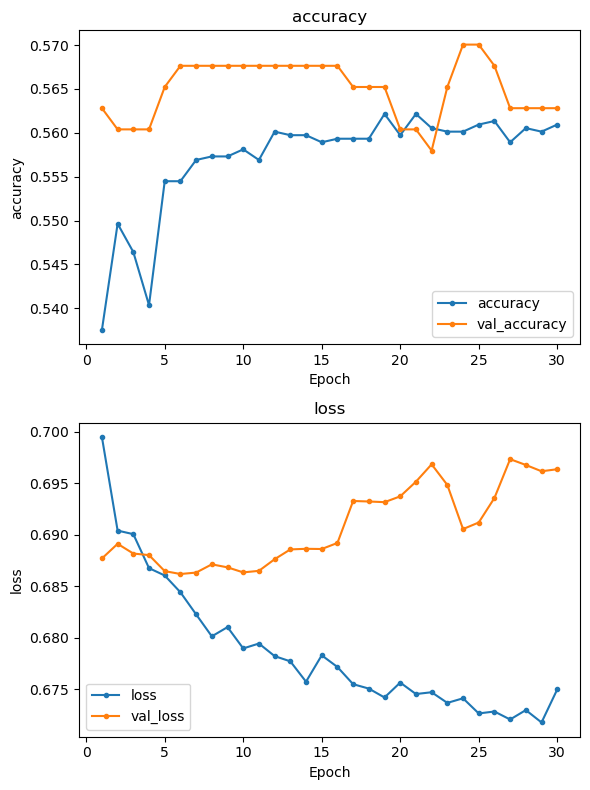

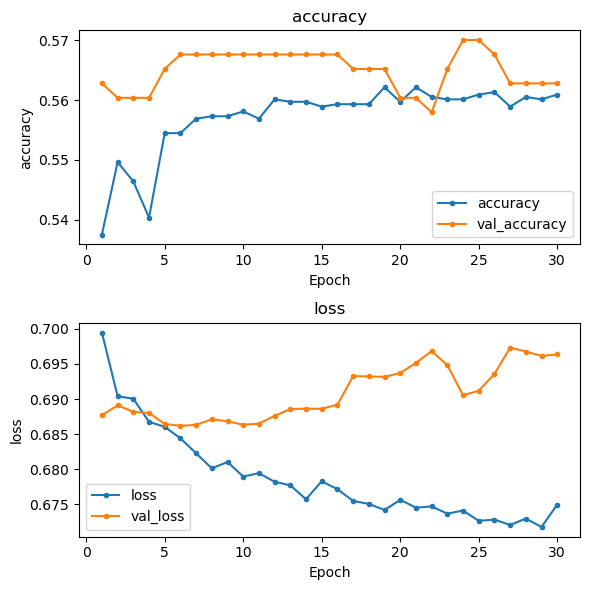


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.56      1.00      0.72      1376
    Positive       1.00      0.01      0.03      1102

    accuracy                           0.56      2478
   macro avg       0.78      0.51      0.37      2478
weighted avg       0.75      0.56      0.41      2478



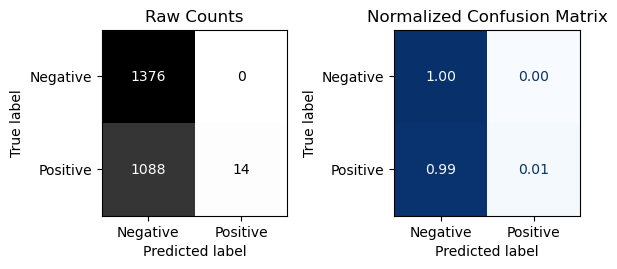

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.62      0.99      0.76       255
    Positive       0.25      0.01      0.01       158

    accuracy                           0.61       413
   macro avg       0.43      0.50      0.39       413
weighted avg       0.48      0.61      0.47       413



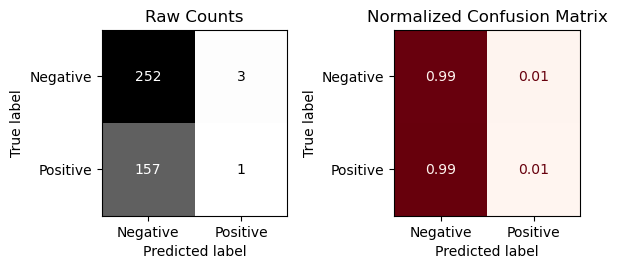

In [48]:
# import evaluate_pyt/orch as fn
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd



# Create vocabulary and tokenizer
vocab = evpy.get_vocab(train_data['review'])

def tokenizer(text):
    tokens = evpy.preprocess_text(text)
    return torch.tensor([vocab.get(word, 0) for word in tokens], dtype=torch.long)

# Create datasets
train_dataset = evpy.AmazonReviewsDataset(train_data['review'], train_data['label'], tokenizer)
val_dataset = evpy.AmazonReviewsDataset(val_data['review'], val_data['label'], tokenizer)
test_dataset = evpy.AmazonReviewsDataset(test_data['review'], test_data['label'], tokenizer)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=evpy.pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=evpy.pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=evpy.pad_collate_fn)

# Define model parameters
VOCAB_SIZE = len(vocab) + 1  # Add 1 for padding
EMBED_DIM = 100
HIDDEN_DIM = 32
OUTPUT_DIM = 1
EPOCHS = 30

# Define the model
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SimpleRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x  # Returning raw logits without applying sigmoid

# Instantiate the model
model = SimpleRNNModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

# Set the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
history = evpy.train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

# Plot training history
evpy.plot_history(history)

# Evaluate the model
results_dict = evpy.evaluate_classification_pytorch(model, 
                                                  X_train=train_loader, 
                                                  X_test=test_loader,
                                                  history=history,
                                                  target_names=["Negative", "Positive"])

# # If results_dict is needed for further use
# train_results = results_dict['train']
# test_results = results_dict['test']

## LSTM

- Epoch 1/30: Train Loss: 0.7025, Train Accuracy: 0.4447; Val Loss: 0.6945, Val Accuracy: 0.4275
- Epoch 2/30: Train Loss: 0.6930, Train Accuracy: 0.4447; Val Loss: 0.6903, Val Accuracy: 0.4275
- Epoch 3/30: Train Loss: 0.6407, Train Accuracy: 0.4447; Val Loss: 0.6326, Val Accuracy: 0.4275
- Epoch 4/30: Train Loss: 0.6020, Train Accuracy: 0.4447; Val Loss: 0.6293, Val Accuracy: 0.4275
- Epoch 5/30: Train Loss: 0.5955, Train Accuracy: 0.4447; Val Loss: 0.6253, Val Accuracy: 0.4275
- Epoch 6/30: Train Loss: 0.5906, Train Accuracy: 0.4447; Val Loss: 0.6147, Val Accuracy: 0.4275
- Epoch 7/30: Train Loss: 0.5845, Train Accuracy: 0.4447; Val Loss: 0.6134, Val Accuracy: 0.4275
- Epoch 8/30: Train Loss: 0.5932, Train Accuracy: 0.4447; Val Loss: 0.6164, Val Accuracy: 0.4275
- Epoch 9/30: Train Loss: 0.5875, Train Accuracy: 0.4447; Val Loss: 0.6194, Val Accuracy: 0.4275
- Epoch 10/30: Train Loss: 0.5820, Train Accuracy: 0.4447; Val Loss: 0.6049, Val Accuracy: 0.4275
- Epoch 11/30: Train Loss: 0.

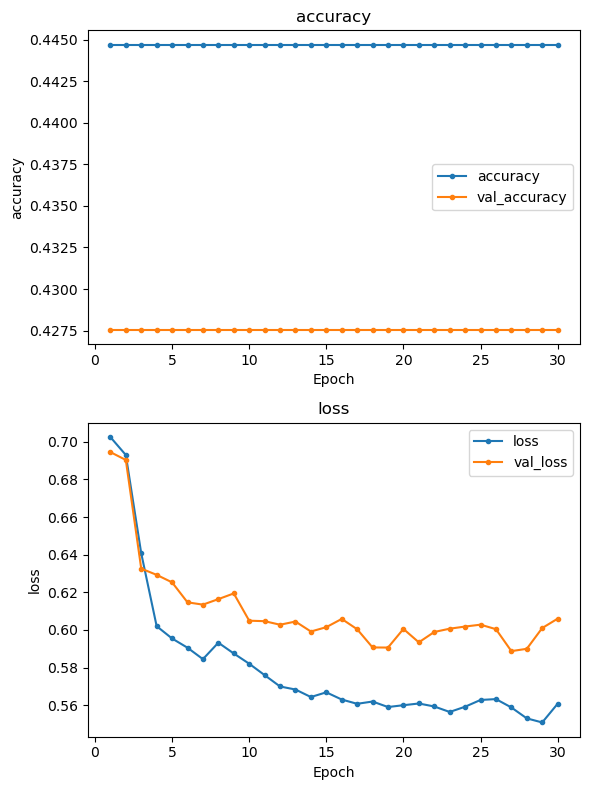

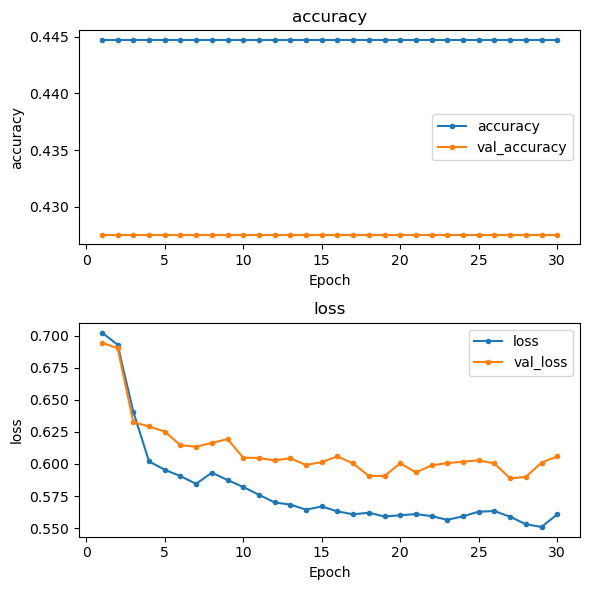


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.87      0.99      0.93      1376
    Positive       0.99      0.82      0.89      1102

    accuracy                           0.91      2478
   macro avg       0.93      0.90      0.91      2478
weighted avg       0.92      0.91      0.91      2478



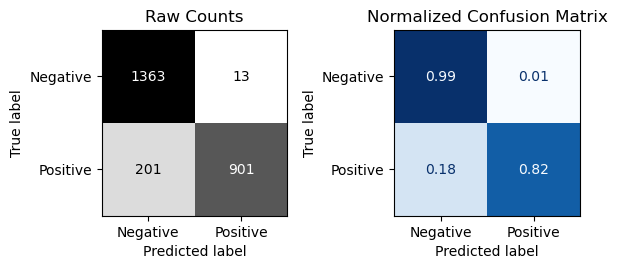

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.86      0.96      0.90       255
    Positive       0.91      0.74      0.82       158

    accuracy                           0.87       413
   macro avg       0.89      0.85      0.86       413
weighted avg       0.88      0.87      0.87       413



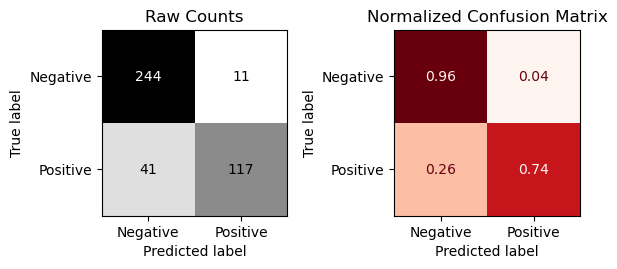

In [53]:
# Model parameters
VOCAB_SIZE = len(vocab) + 1  # Add 1 for padding
EMBED_DIM = 100
LSTM_HIDDEN_DIM = 64
OUTPUT_DIM = 1  # For binary classification
EPOCHS = 30

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_dim, output_dim, dropout=0.5, binary_task=True):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm1 = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True, dropout=0.1, bidirectional=False)
        self.lstm2 = nn.LSTM(lstm_hidden_dim, lstm_hidden_dim, batch_first=True, dropout=0.1, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
        
        if binary_task:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.global_max_pool(x.transpose(1, 2)).squeeze(2)
        x = self.fc(x)
        x = self.activation(x)
        return x

# Instantiate the model
model = LSTMModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, output_dim=OUTPUT_DIM, binary_task=True)

# Set the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
history = evpy.train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

# Plot training history
evpy.plot_history(history)

# Evaluate the model
results_dict = evpy.evaluate_classification_pytorch(model, 
                                                  X_train=train_loader, 
                                                  X_test=test_loader,
                                                  history=history,
                                                  target_names=["Negative", "Positive"])

# # If results_dict is needed for further use
# train_results = results_dict['train']
# test_results = results_dict['test']

## Adding Early Stopping

## 👉📌BOOKMARK

In [59]:
class EarlyStopping:
    """
    Early stopping class for monitoring the validation loss during training and stopping the training process
    if the validation loss does not improve for a certain number of epochs.

    Args:
        patience (int): Number of epochs to wait for improvement in validation loss before stopping the training.
        verbose (bool): If True, prints the early stopping counter during training.
        delta (float): Minimum change in validation loss to be considered as an improvement.

    Attributes:
        patience (int): Number of epochs to wait for improvement in validation loss before stopping the training.
        verbose (bool): If True, prints the early stopping counter during training.
        delta (float): Minimum change in validation loss to be considered as an improvement.
        best_score (float): Best validation loss score achieved so far.
        early_stop (bool): Flag indicating whether to stop the training or not.
        counter (int): Counter for the number of epochs without improvement in validation loss.
        best_loss (float): Best validation loss achieved so far.
    """

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        """
        Method to update the early stopping criteria based on the validation loss.

        Args:
            val_loss (float): Current validation loss.

        Returns:
            None
        """
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.counter = 0
            
            
            
            
def train_model_early_stopping(model, criterion, optimizer, train_loader, val_loader, epochs, patience=5):
    
    # Initialize the history dictionary
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }
    
    
    
    class History():
        def __init__(self, history_dict=None):
            if history_dict is None:
                history_dict = {
                    'loss': [],
                    'val_loss': [],
                    'accuracy': [],
                    'val_accuracy': []
                }
            self.history = history_dict
            n_epochs = len(history_dict['loss'])
            self.epoch = list(range(1, n_epochs+1))
            
            
    # Initialize the EarlyStopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        # Initialize the running loss and correct predictions counters
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Loop over the training data
        for inputs, labels in train_loader:
            labels = labels.unsqueeze(1).float()  # Reshape labels for compatibility with BCEWithLogitsLoss
            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            running_loss += loss.item()  # Update running loss

            # Get predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate the training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)

        
        ## TO DO: Try replacing the validation phase with the get_predictions function
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                labels = labels.unsqueeze(1)  # Reshape labels for compatibility with BCEWithLogitsLoss
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_running_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct_predictions += (preds == labels).sum().item()
                val_total_predictions += labels.size(0)

        # Calculate the validation loss and accuracy
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        msg = f'- Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}; '
        msg += f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}'
        print(msg)
    
    
        ## Check if early stopping is triggered
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    return History(history)

In [60]:

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_dim, output_dim, dropout=0.5, binary_task=True):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm1 = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True, dropout=0.1, bidirectional=False)
        self.lstm2 = nn.LSTM(lstm_hidden_dim, lstm_hidden_dim, batch_first=True, dropout=0.1, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
        
        if binary_task:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.global_max_pool(x.transpose(1, 2)).squeeze(2)
        x = self.fc(x)
        x = self.activation(x)
        return x



# Model parameters
VOCAB_SIZE = len(vocab) + 1  # Add 1 for padding
EMBED_DIM = 100
LSTM_HIDDEN_DIM = 128
OUTPUT_DIM = 1  # For binary classification
EPOCHS = 30


# Instantiate the model
model = LSTMModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, output_dim=OUTPUT_DIM, binary_task=True)

# Set the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
# history = evpy.train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS)
history = train_model_early_stopping(model, criterion, optimizer, train_loader, val_loader, EPOCHS, patience=5)

# Plot training history
evpy.plot_history(history)

# Evaluate the model
results_dict = evpy.evaluate_classification_pytorch(model, 
                                                  X_train=train_loader, 
                                                  X_test=test_loader,
                                                  history=history,
                                                  target_names=["Negative", "Positive"])

# # If results_dict is needed for further use
# train_results = results_dict['train']
# test_results = results_dict['test']

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


- Epoch 1/30: Train Loss: 0.6997, Train Accuracy: 0.4447; Val Loss: 0.6937, Val Accuracy: 0.4275
- Epoch 2/30: Train Loss: 0.6933, Train Accuracy: 0.4447; Val Loss: 0.6932, Val Accuracy: 0.4275
- Epoch 3/30: Train Loss: 0.6863, Train Accuracy: 0.4447; Val Loss: 0.6346, Val Accuracy: 0.4275
- Epoch 4/30: Train Loss: 0.6189, Train Accuracy: 0.4447; Val Loss: 0.6353, Val Accuracy: 0.4275
EarlyStopping counter: 1 out of 5


In [ ]:
# # Define a function for building an LSTM model
# from tensorflow.keras import layers, optimizers, regularizers
# from tensorflow.keras.models import Sequential


# # @tf.function
# def build_lstm_model(text_vectorization_layer, binary_task=True):
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()

#     if binary_task == True:
#         final_activation = "sigmoid"  # ?
#         loss_func = "binary_crossentropy"
#         nunits_output = 1
#     else:
#         final_activation = "softmax"  # ?
#         loss_func = "sparse_categorical_crossentropy"
#         nunits_output = len(classes)

#     # Define sequential model with pre-trained vectorization layer and *new* embedding layer
#     lstm_model = Sequential(
#         [
#             text_vectorization_layer,
#             layers.Embedding(
#                 input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
#             ),
#         ]
#     )

#     # Add *new* LSTM layer
#     lstm_model.add(layers.LSTM(64, recurrent_dropout=0.1, return_sequences=True))
#     lstm_model.add(layers.Dropout(0.5))
#     lstm_model.add(layers.LSTM(64, return_sequences=True))
#     lstm_model.add(layers.GlobalMaxPooling1D())

#     # Add output layer
#     lstm_model.add(layers.Dense(nunits_output, activation=final_activation))

#     # Compile the model
#     lr_schedule = optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
#     )  # 0.9)
#     optimizer = optimizers.Adam(learning_rate=lr_schedule)
#     lstm_model.compile(
#         optimizer=optimizer,  #'adam',
#         loss=loss_func,  # "sparse_categorical_crossentropy",
#         metrics=[  # tf.metrics.Accuracy(name='accuracy'),
#             "accuracy",
#             tf.metrics.Recall(name="recall")
#             # tf.keras.metrics.Recall(class_id=0, name="recall_class_0"),
#             # tf.keras.metrics.Recall(class_id=1, name="recall_class_1"),
#         ],
#     )

#     lstm_model.summary()
#     return lstm_model

In [ ]:
# EMBED_DIM = 50
# classes = y_train.unique()
# # Build the lstm model and specify the vectorizer
# lstm_model = build_lstm_model(sequence_vectorizer)

# # Defien number of epocs
# EPOCHS = 30

# # Fit the model
# history = lstm_model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks(),
# )

# fn.evaluate.plot_history(history)

In [54]:
# # Obtain the results
# results = fn.evaluate.evaluate_classification_network(
#     lstm_model, X_train=train_ds, 
#     X_test=test_ds,# history=history
# );

> ADD SAVING MODEL

In [ ]:
# # Saving model in tf format 
# fname_model_lstm = FPATHS['models']['nn']['LSTM_dir']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
# lstm_model.save(fname_model_lstm, save_format='tf')

In [ ]:
raise Exception("Below not yet updated for Pytorch")

### RNN Model 2

In [ ]:
# def build_gru_model_bi_pool(text_vectorization_layer, binary_task=True):
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    
#     if binary_task == True:
#         final_activation = "sigmoid"  # ?
#         loss_func = "binary_crossentropy"
#         nunits_output = 1
#     else:
#         final_activation = "softmax"  # ?
#         loss_func = "sparse_categorical_crossentropy"
#         nunits_output = len(classes)
    
#     # Define sequential model with pre-trained vectorization layer and *new* embedding layer
#     model = Sequential(
#         [
#             text_vectorization_layer,
#             layers.Embedding(
#                 input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
#             ),
#         ]
#     )
#     model = Sequential([
#         text_vectorization_layer,
#         layers.Embedding(input_dim=VOCAB_SIZE,
#                       output_dim=EMBED_DIM,
#                       input_length=SEQUENCE_LENGTH)])
        
#     # Add bidirectional component to GRU layer 
#     model.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
#     # Add a pooling layer *new
#     model.add(layers.GlobalMaxPooling1D())
    
#     # Output layer
#     model.add(layers.Dense(nunits_output, activation=final_activation))
                     
#     # optimizer = optimizers.legacy.Adam()
#     # Compile the model
#     lr_schedule = optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
#     )  # 0.9)
#     optimizer = optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(optimizer=optimizer, 
#                   loss=loss_func,
#                               metrics=[  # tf.metrics.Accuracy(name='accuracy'),
#             "accuracy",
#             tf.metrics.Recall(name="recall")
#                               ])
#     model.summary()
#     return model

In [ ]:
# # Build the lstm model and specify the vectorizer
# bidirection_model = build_gru_model_bi_pool(sequence_vectorizer)

# # Defien number of epocs
# EPOCHS = 30

# # Fit the model
# history = bidirection_model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks(),
# )
# fn.evaluate.plot_history(history)

In [ ]:
# # Obtain the results
# results = fn.evaluate.evaluate_classification_network(
#     bidirection_model, X_train=train_ds, 
#     X_test=test_ds,# history=history
# );

In [ ]:
# # Saving model in tf format 
# fname_model_gru = FPATHS['models']['nn']['GRU_dir']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
# bidirection_model.save(fname_model_gru, save_format='tf')